# Learn to Optimize

+ experiment with hand-picked diagonal matrices 
+ initialize a cluster of points non-isotropic and optimize step sizes
+ generalize formulas to nonisotropic x 
+ associative memory (hopfield networks, multi-well real life problems, goal is to put this tech into a paper) 
+ compute decay with k, study optimization of step sizes with autodiff 
+ diagonal matrix optimal step sizes

TODO: 
+ find a function that yields a complicated optimization landscape 
+ use a update function that isn't just linear (eg. could be resnet) 
+ read about quasi newton 

## GD Approximation to Linear

The goal is to simulate $ \dot{x}_t = -A x_t $ for $t \in [0, \infty)$ and $A$ a psd matrix. This is the gradient flow of the loss $\mathcal{L}(x_t) = \frac{1}{2} x_t^T A x_t$ and it is expected to converge to $x_\infty = 0$ at different rates depending on the initial point $x_0$ and the properties of $A$. We would like to optimize over a model class $\hat{f} \in \mathcal{F}$ the objective 

$
\mathbb{E}_{x \sim p}[ \|\hat{f}(x) - x_\infty\|^2] = \|\hat{f}(x)\|_{\mathcal{L}^2(p)}
$

and in particular we are interested in model classes that incorporate gradient descent. Let $\mathcal{F}_k = \{f_\eta : \eta \in \mathbb{R}^k\}$ contain functions that compute $k$ steps of gradient descent. In other words, the parameters $\eta$ are step sizes and $f_\eta$ is defined by

$
\begin{align*}
f_\eta(x) = x_k \text{ where } \begin{cases} x_{i+1} = x_i - \eta_i A x_i & \quad i > 0 \\ x_0 = x & \\ \end{cases}
\end{align*}
$

Interestingly, this model class is equivalent to polynomial regression over matrices! That is, $f_\eta(x) \in \mathcal{F}_k$ is equivalently written as 

$
f_\eta(x) = \left[ I + \sum_{i=1}^k \theta_i A^i \right] x
$

for some $\theta \in \mathbb{R}^k$. The relationship between $\theta$ and $\eta$ is $\theta_i = (-1)^i e_i(\eta_1, \ldots, \eta_k)$ where $e_i(x)$ is the $i$th elementary symmetric polynomial.

where we used the induction hypothesis (at index $k-1$) in the second line. What is nice about this relationship is that we can invoke [Vieta's Formulas](https://en.wikipedia.org/wiki/Vieta%27s_formulas) to _invert_ the relationship and compute $(\eta_i)_{1 \leq i \leq k}$ from $(\theta_i)_{1 \leq i \leq k}$. Vieta's formulas state that the $k$ (potentially complex) roots $(r_i)_{1 \leq i \leq k}$ of the polynomial $p_\theta(x) = a_k x^k + \ldots + a_1 x + a_0$ satisfy, 

$
 \eta_i(r_1, \ldots, r_k) = (-1)^i \frac{a_{n-i}}{a_n}
$

where we interpret $\theta_0 = 1$ and $e_0(\eta_1, \ldots, \eta_k) = 1$. It follows that: 
- Given step sizes $(\eta_1, \ldots, \eta_k)$, the corresponding regression coefficients are $\theta_i = (-1)^i e_i(\eta_1, \ldots, \eta_n)$. As a consequence, the discretization error is invariant to ordering of the step sizes. 
- Given regression coefficients $(\theta_1, \ldots, \theta_k)$, the corresponding step sizes (which are permutation invariant) are the roots of the polynomial $p_\theta(x) = x^n + \theta_1 x^{n-1} + \ldots + \theta_{n-1} x + \theta_n$. 

## Rotationally Invariant Case

It turns out that if $x \sim p$ is rotationally invariant, then we can solve for the optimal regression coefficients by diagonalizing the problem. Let $\lambda_1, \ldots, \lambda_k$ be the eigenvalues of $A$ and for convenience write $\lambda_0 = 1$. Then we have 

$
\|f\|_{\mathcal{L}(p)}^2 = \sum_{j=1}^d \mathbb{E}\left[ \left(x_j + \sum_{i=1}^k \theta_i x_j \lambda_j^i\right)^2\right] = \sum_{j=1}^d \mathbb{E}[x_j^2] \left(1+ \sum_{i=1}^k \theta_i \lambda_j^i \right)^2
$

and observe that $\mathsf{Cov}[x]=I_d$ by rotation invariance. (I think this is implied by rotation invariance, since it has to be true that $U \Sigma_x U^T$ is invariant to unitary $U$).

It turns out that we can rewrite this as a PSD quadratic form over $\theta \in \mathbb{R}^{k+1}$ subject to a linear constraint. The linear constraint will be $\theta_0 = 1$. Observe that 
$
\left(1 + \sum_{i=1}^k \theta_i \lambda_j^i \right)^2 = \langle \theta, \vec{\lambda}_j  \rangle \langle \vec{\lambda}_j, \theta \rangle = \theta^T (\vec{\lambda}_j \vec{\lambda}_j^T) \theta
$
where $\vec{\lambda}_j = [1\ \lambda_j\ \lambda_j^2 \ \ldots \ \lambda_j^k]$. So the relevant quadratic form is 
$
B : = \sum_{j=1}^d \vec{\lambda}_j \vec{\lambda}_j^T. 
$
which can be full rank whenever $k < d$. It is straightforward to show with Lagrange multipliers that the solution to the PSD quadratic program

$
\min\ \theta^T B \theta \qquad \text{ such that } \quad \theta_0 = 1
$

is 

$
\theta^* = \frac{[B^{-1}]_{:, 0}}{[B^{-1}]_{0, 0}}
$


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipyvolume as ipv
from main import *
import scipy as sp 
import scipy.linalg

d = 10
grid = np.arange(-10, 10, 0.1)

A_ = np.random.normal(size=(d, d))
A = (A_ + A_.T)/np.sqrt(2 * d)
objs = np.array([[obj_value(A, [e1, e2]) for e1 in grid] for e2 in grid])

X, Y = np.meshgrid(grid, grid)

ipv.figure()
ipv.pylab.plot_surface(X, objs, Y)
ipv.show()



Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Wishart Matrices

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipyvolume as ipv
from main import *
import scipy as sp 
import scipy.linalg




# Optimization Landscape

In [3]:
grid = np.arange(-5, 5, 0.1)


X, Y = np.meshgrid(grid, grid)
opt_regr = mtx_optimal_regr(W, 2)
opt_steps = regr_to_steps(opt_regr)



NameError: name 'W' is not defined

Regression coefficients landscape

In [ ]:
ipv.figure()

objs = np.array([[regr_obj_value(W, [e1, e2]) for e1 in grid] for e2 in grid])

ipv.pylab.plot_surface(X, Y, np.log(objs))
ipv.pylab.scatter(opt_regr[1], opt_regr[2], np.log(regr_obj_value(W, opt_regr[1:])), color="green")
ipv.pylab.scatter(0, 0, np.log(obj_value(W, [0, 0])), color="blue")
ipv.show()

Step size landscape

In [ ]:
ipv.figure()
ipv.pylab.plot_surface(X, Y, np.log(objs))
ipv.pylab.scatter(opt_steps[0], opt_steps[1], np.log(obj_value(W, opt_steps)), color="green")
ipv.pylab.scatter(0, 0, np.log(obj_value(W, [0, 0])), color="blue")
ipv.pylab.scatter(vanilla_steps[0], vanilla_steps[1], np.log(obj_value(W, vanilla_steps[:2])), color="yellow")
ipv.show()



## Trajectories of Gradient Descent

In [14]:
def true_gd_trajectory(A, inits, times):
    # inits is N by D
    # A is D by D 
    # times is T
    #output is N by T by D 
    flows = np.stack([sp.linalg.expm(-t * A) for t in times], axis=0)
    return np.transpose(flows @ inits.T, (2, 0, 1))

def plot_trajectory(X, proj, fmt="-", color="k"):
    # X is N by D sequence of D-dimensional points
    # proj is 2 by D
    plt.plot(*(X@proj).T, fmt, color=color)
    
def plot_levelsets(A, proj, radii=[1]):
    for r in radii:
        eva, eve = np.linalg.eigh(A)
        U, S, Vt = np.linalg.svd(proj.T @ (eve * (1/np.sqrt(eva))[None, :])) 
        angles = np.arange(0, 2*np.pi+0.1, 0.1)
        X, Y = np.cos(angles), np.sin(angles)
        pts = r * U @ np.diag(S) @ np.stack((X, Y), axis=0)
        plt.plot(*pts, lw=0.5, color="k")
   
    

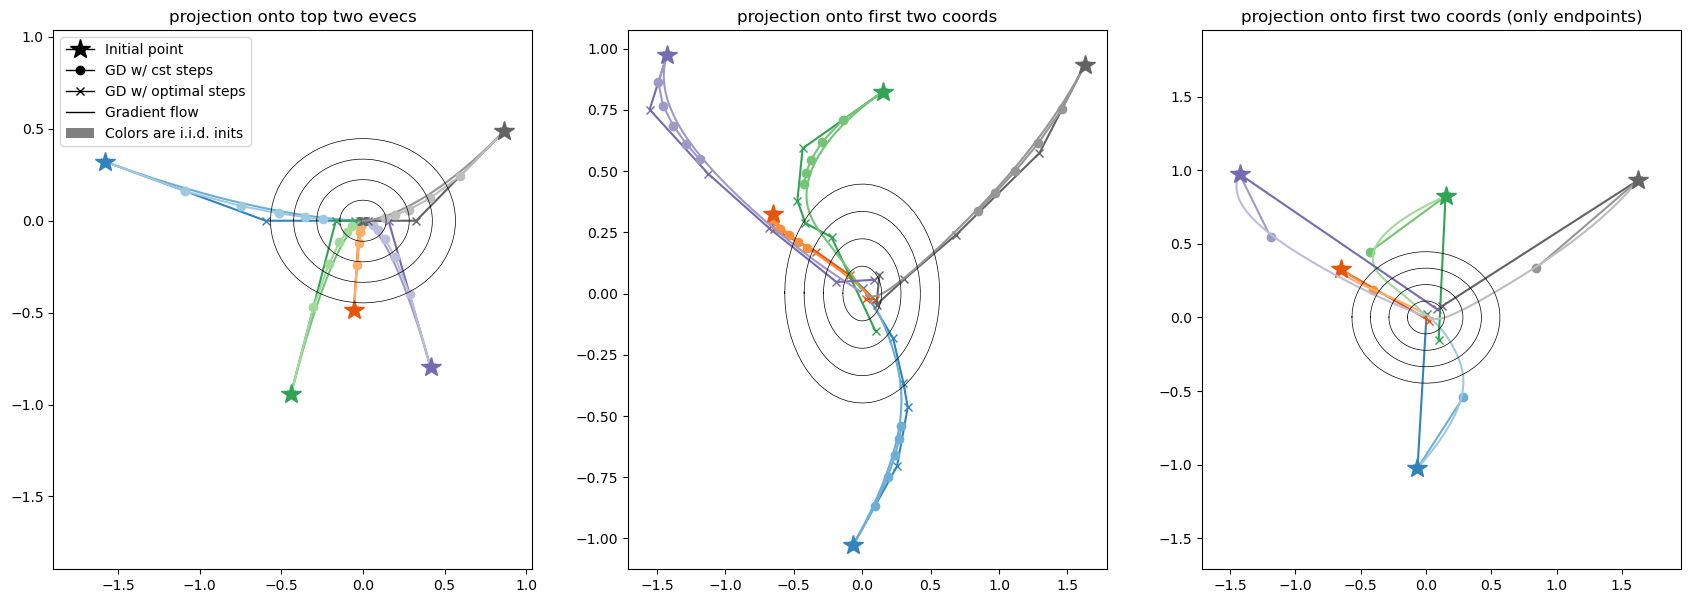

In [38]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


d = 10
gd_steps = 5
A = np.random.normal(size=(d,2*d))
W = ( A @ A.T )/(2*d)

S, U =  np.linalg.eigh(W)
PROJ = U[:, -2:]
PROJ_eye = np.eye(d)[:, :2]

opt_regr = mtx_optimal_regr(W, gd_steps)
opt_steps = regr_to_steps(opt_regr)[::-1]


vanilla_steps = np.ones((gd_steps,)) * (0.5/np.max(S))
objs = np.array([[obj_value(W, [e1, e2]) for e1 in grid] for e2 in grid])


inits = np.random.normal(size=(5, 10))
times = np.arange(0, 10, 0.01)

true_trajectories = true_gd_trajectory(W, inits, times)
gd_trajectories = gd_trajectory(W, inits, opt_steps)
vani_gd_trajectories = gd_trajectory(W, inits, vanilla_steps)

plt.subplot(1, 3, 1)
plt.title("projection onto top two evecs")
cmap = mpl.colormaps.get_cmap('tab20c')

for i in range(len(true_trajectories)):
    plot_trajectory(gd_trajectories[i], PROJ, fmt="x-", color=cmap.colors[4*i])
    plot_trajectory(true_trajectories[i], PROJ, color=cmap.colors[4*i + 1])
    plot_trajectory(vani_gd_trajectories[i], PROJ, fmt="o-", color=cmap.colors[4*i+2])
    plt.plot(*(gd_trajectories[i, 0] @ PROJ), '*', markersize=15, color=cmap.colors[4*i])

plot_levelsets(W, PROJ, radii=np.arange(0.2, 1, 0.2))
plt.xlim(1.2 * np.min(inits@PROJ), 1.2*np.max(inits@PROJ))
plt.ylim(1.2 * np.min(inits@PROJ), 1.2*np.max(inits@PROJ)) 


legend_elements = [Line2D([0], [0], color='k', marker='*', lw=1, label='Initial point', markersize=15),
                   Line2D([0], [0], color='k', marker='o', lw=1, label='GD w/ cst steps'),
                   Line2D([0], [0], marker='x', color='k', lw=1, label='GD w/ optimal steps'),
                   Line2D([0], [0], color='k', lw=1, label='Gradient flow'), 
                   Patch(facecolor="grey", label='Colors are i.i.d. inits')]

# Create the figure
plt.gca().legend(handles=legend_elements)


plt.subplot(1, 3, 2)
plt.title("projection onto first two coords")
for i in range(len(true_trajectories)):
    plot_trajectory(gd_trajectories[i], PROJ_eye, fmt="x-", color=cmap.colors[4*i])
    plot_trajectory(vani_gd_trajectories[i], PROJ_eye, fmt="o-", color=cmap.colors[4*i + 1])
    plot_trajectory(true_trajectories[i], PROJ_eye, color=cmap.colors[4*i+1])
    plt.plot(*(gd_trajectories[i, 0] @ PROJ_eye), '*', markersize=15, color=cmap.colors[4*i])
plot_levelsets(W, PROJ, radii=np.arange(0.2, 1, 0.2))


plt.subplot(1, 3, 3)
plt.title("projection onto first two coords (only endpoints)")
for i in range(len(true_trajectories)):
    plot_trajectory(gd_trajectories[i, (0, -1), :], PROJ_eye, fmt="x-", color=cmap.colors[4*i])
    plot_trajectory(vani_gd_trajectories[i, (0, -1), :], PROJ_eye, fmt="o-", color=cmap.colors[4*i + 1])
    plot_trajectory(true_trajectories[i], PROJ_eye, color=cmap.colors[4*i+2])
    plt.plot(*(gd_trajectories[i, 0] @ PROJ_eye), '*', markersize=15, color=cmap.colors[4*i])
plot_levelsets(W, PROJ, radii=np.arange(0.2, 1, 0.2))
plt.xlim(1.2 * np.min(inits@PROJ_eye), 1.2*np.max(inits@PROJ_eye))
plt.ylim(1.2 * np.min(inits@PROJ_eye), 1.2*np.max(inits@PROJ_eye))



plt.gcf().set_size_inches(21, 7)
plt.savefig('gd_trajectories.pdf', dpi=120, bbox_inches='tight')
plt.show()

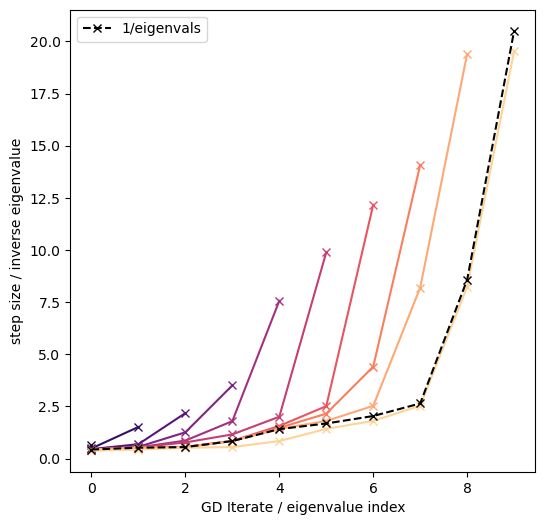

In [21]:
cmap = mpl.colormaps.get_cmap('magma')

for _gd_steps in range(d+1):
    _opt_regr = mtx_optimal_regr(W, _gd_steps)
    _opt_steps = regr_to_steps(_opt_regr)[::-1]
    
    plt.plot(range(_gd_steps), _opt_steps, "x-", color=cmap(_gd_steps / (d+1)))
plt.plot(range(len(1/S)), 1/S[::-1], "kx--", label="1/eigenvals")
plt.legend()
plt.gcf().set_size_inches(6, 6)
plt.xlabel('GD Iterate / eigenvalue index')
plt.ylabel('step size / inverse eigenvalue')
plt.show()

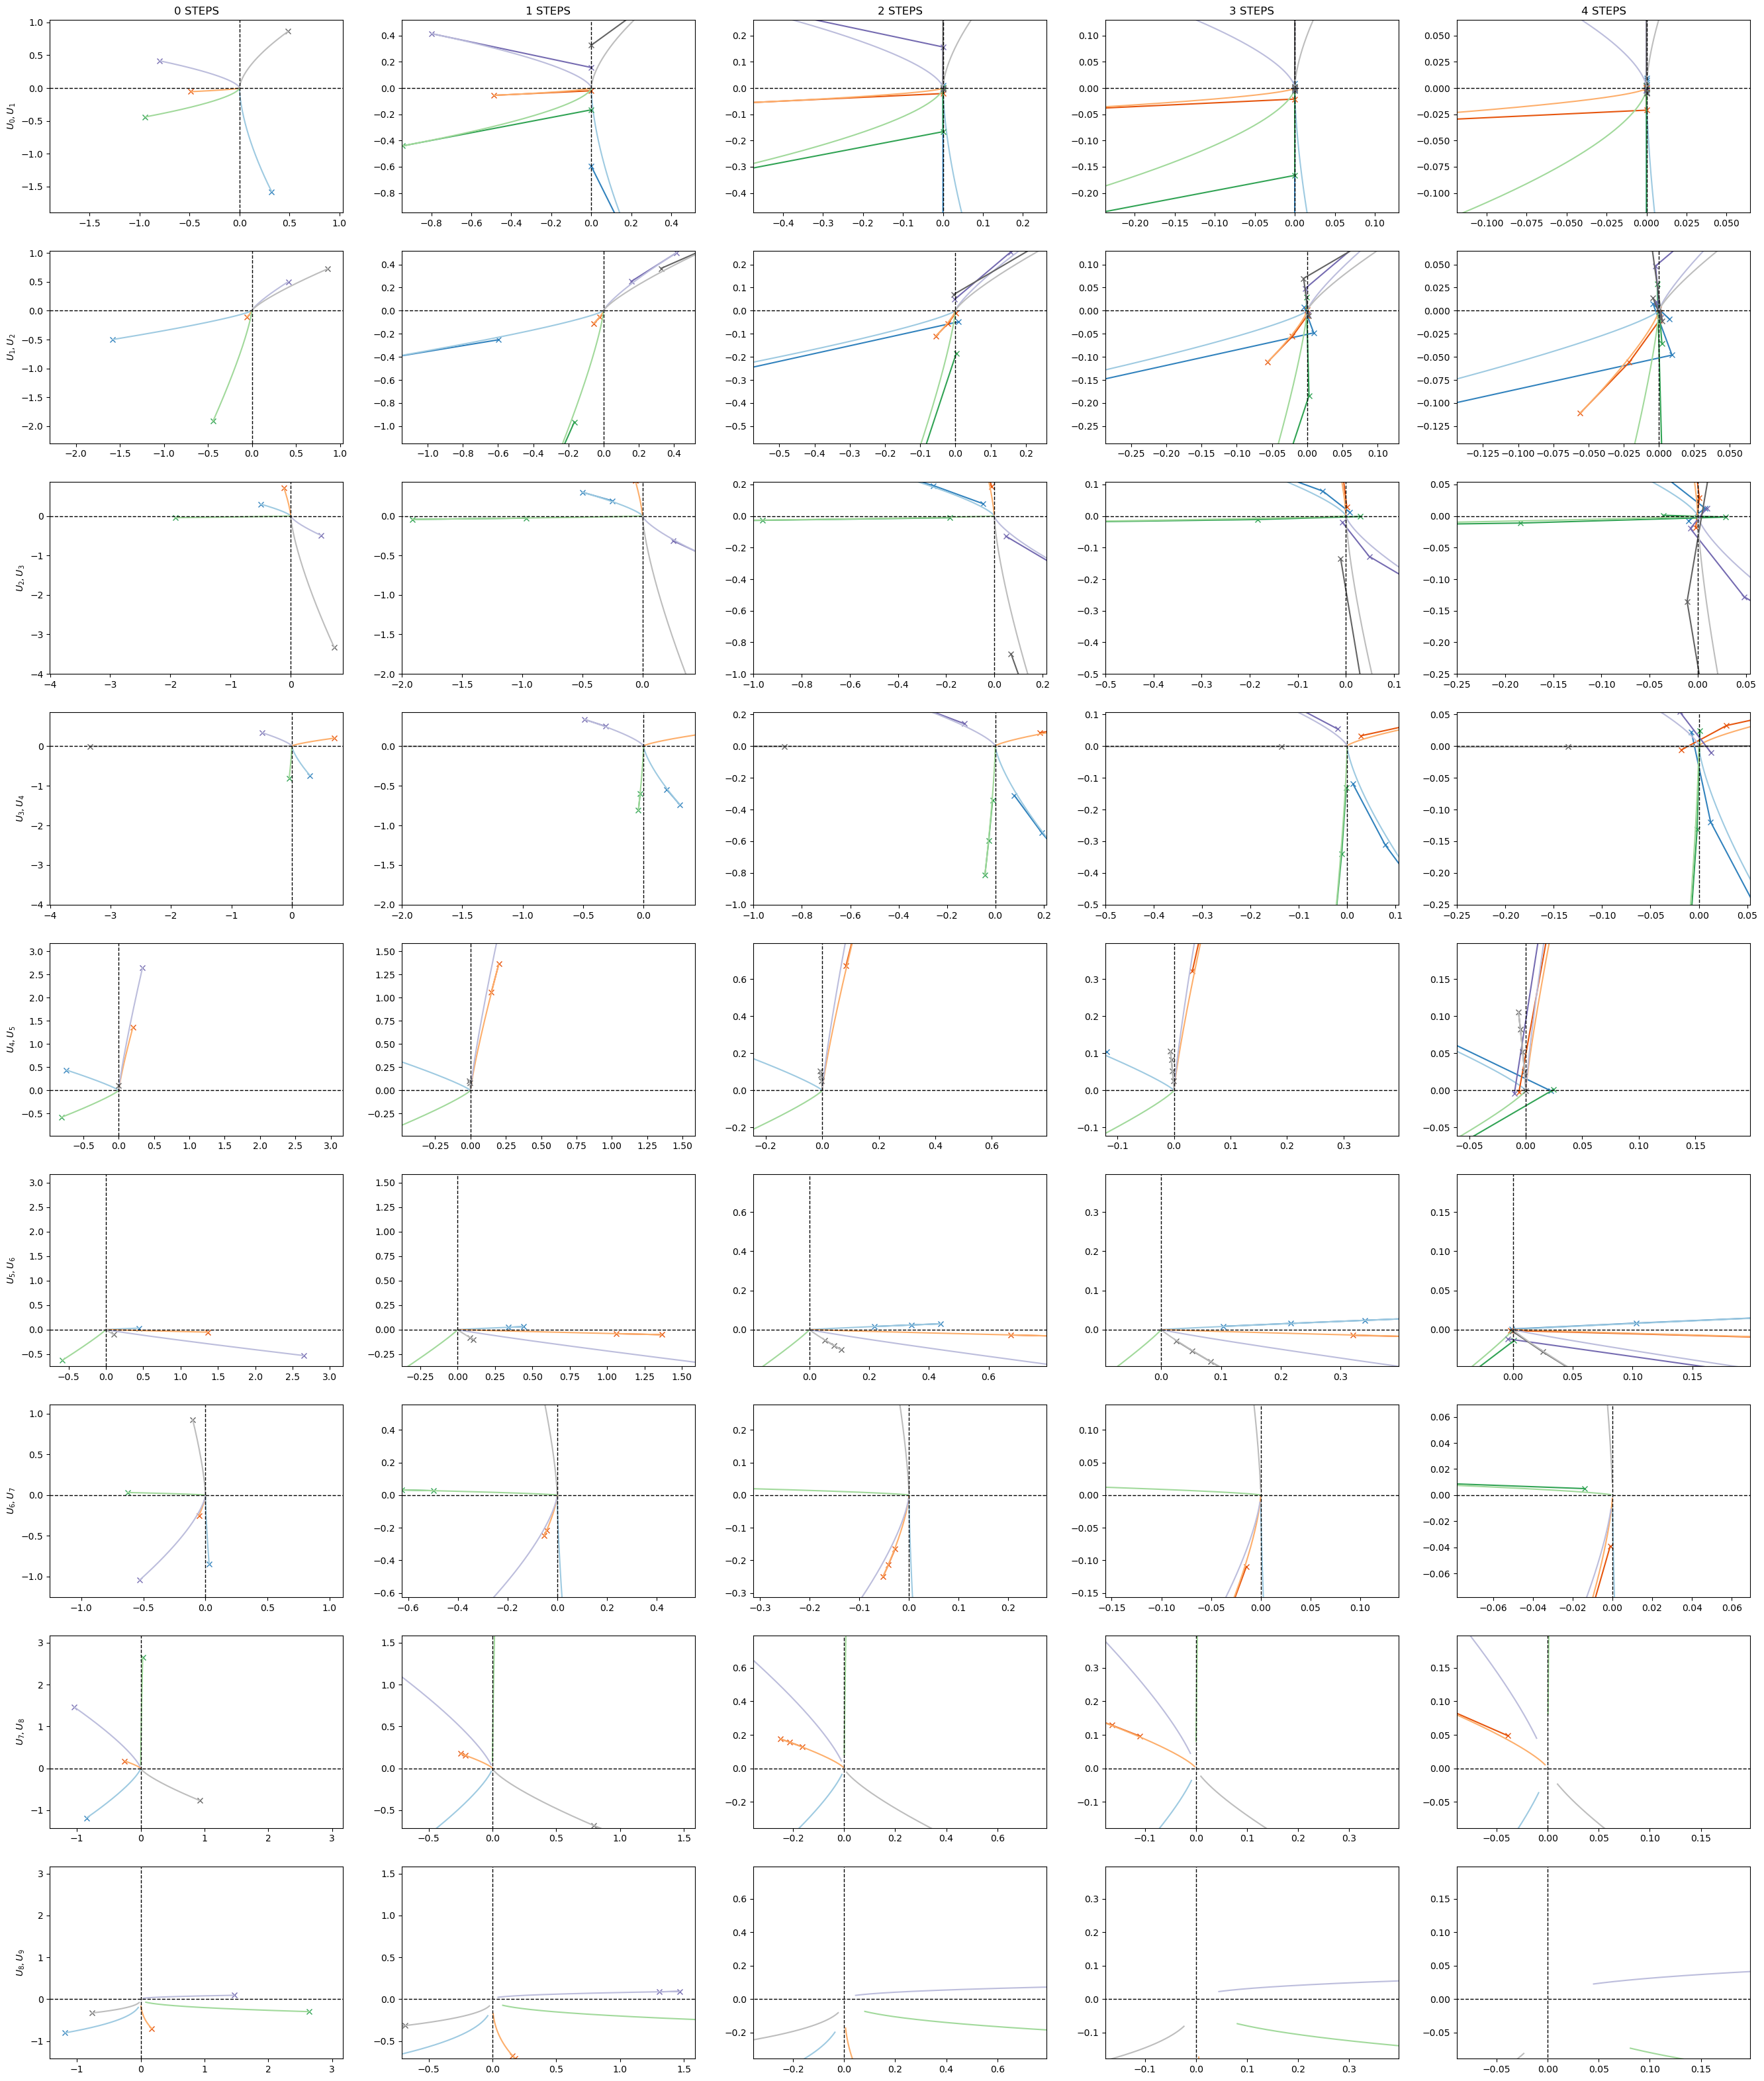

In [39]:

def trajectory_evecs_superplot(proj, trajectories, true_trajectories):
    '''
    :param proj: an ordered list of projection vectors of size [k eigenvectors x d dimension]
    :param trajectories: a list of size N x steps x d of trajectories
    :param true_trajectories: a list of size N x timesteps x d of trajectories
    :return:
    '''
    K = len(proj) - 1
    N_steps = trajectories.shape[1]

    cmap = mpl.colormaps.get_cmap('tab20c')

    for k in range(K):
        cur_proj = proj[:, k:k+2]
        init = trajectories[:, 0] @ cur_proj
        lims = np.array([1.2 * np.min(init), 1.2 * np.max(init)])
        
        for n in range(1, N_steps):
            plt.subplot(K, N_steps, k*N_steps + n + 1)
            if(k==0):
                plt.title(f'{n-1} STEPS')
            if(n==1):
                plt.ylabel(f'$U_{k}, U_{k+1}$')
                
            plt.xlim(*(0.5**(n-1) * lims))
            plt.ylim(*(0.5**(n-1) * lims))
            
            # make the plot ...
            for i, traj in enumerate(trajectories):
                plot_trajectory(trajectories[i, :n], cur_proj, color=cmap(4*i), fmt="x-")
                plot_trajectory(true_trajectories[i], cur_proj, color=cmap(4*i+2))
            plt.plot(lims, [0, 0], "k--", linewidth=1)
            plt.plot([0, 0], lims, "k--", linewidth=1)


S, U =  np.linalg.eigh(W)

trajectory_evecs_superplot(U[:, ::-1], gd_trajectories, true_trajectories)
plt.gcf().set_size_inches(40, 40)
plt.savefig("convergence_superplot.pdf", dpi=120, bbox_inches="tight")
plt.show()

# Handcrafted diagonal matrices

In [23]:

def stepsizes_vs_spectrum(A, log=False):
    d = len(A)
    S, U = np.linalg.eigh(A)
    cmap = mpl.colormaps.get_cmap('magma')

    for _gd_steps in range(d+1):
        _opt_regr = mtx_optimal_regr(A, _gd_steps)
        _opt_steps = np.sort(regr_to_steps(_opt_regr))
        if(log):
            plt.plot(range(_gd_steps), np.log(_opt_steps), "x-", color=cmap(_gd_steps / (d+1)))
        else:
            plt.plot(range(_gd_steps), _opt_steps, "x-", color=cmap(_gd_steps / (d+1)))
      
    if(log):
        plt.plot(range(len(1/S)), np.log(1/S[::-1]), "kx--", label="1/eigenvals")
    else:
        plt.plot(range(len(1/S)), 1/S[::-1], "kx--", label="1/eigenvals")
    plt.legend()
    plt.gcf().set_size_inches(6, 6)
    plt.xlabel('GD Iterate / eigenvalue index')
    plt.ylabel('step size / inverse eigenvalue')

# Wigner

$d=10$

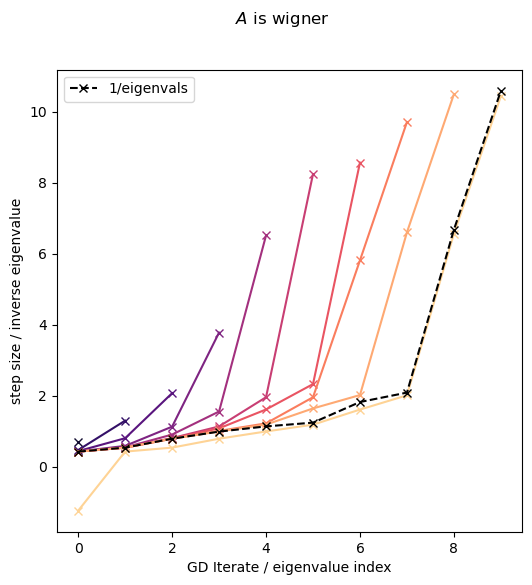

In [24]:
d = 10
A = np.random.normal(size=(d,2*d))
W = ( A @ A.T )/(2*d)
stepsizes_vs_spectrum(W)

plt.suptitle("$A$ is wigner")
plt.show()

Wigner 
$d = 50$

/var/folders/kz/fhh7xhmx7ds_wrvlc_ddhr4m0000gn/T/ipykernel_27733/4251269495.py:10: RuntimeWarning: invalid value encountered in log
  plt.plot(range(_gd_steps), np.log(_opt_steps), "x-", color=cmap(_gd_steps / (d+1)))


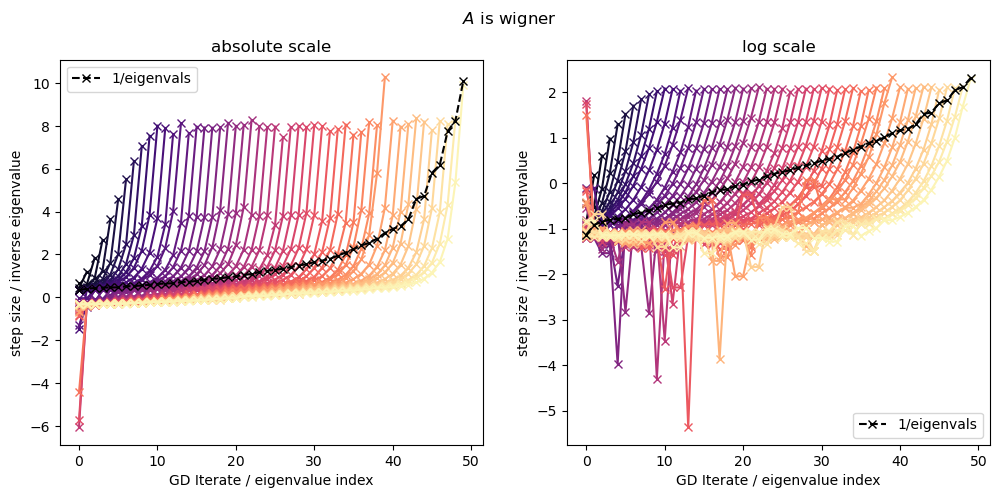

In [30]:
d = 50

A = np.random.normal(size=(d,2*d))
W = ( A @ A.T )/(2*d)

plt.subplot(1, 2, 1)
plt.title('absolute scale')
stepsizes_vs_spectrum(W)

plt.subplot(1, 2, 2)
plt.title('log scale')
stepsizes_vs_spectrum(W, log=True)
plt.gcf().set_size_inches(12, 5)


plt.suptitle("$A$ is wigner")
plt.show()

 Identity 

In [ ]:
A = np.diag(np.ones((10,)) + 0.0001 * np.arange(10))
plt.subplot(1, 2, 1)
plt.title('absolute scale')
stepsizes_vs_spectrum(A)
plt.subplot(1, 2, 2)
plt.title("log scale")
stepsizes_vs_spectrum(A, log=True)
plt.gcf().set_size_inches(10, 5)

plt.suptitle("$A =$ diag$(10^i : i=1\\dots10)$")
plt.show()



Diagonal, ill conditioned

In [ ]:
A = np.diag( 10**np.arange(10) )
plt.subplot(1, 2, 1)
plt.title('absolute scale')
stepsizes_vs_spectrum(A)
plt.subplot(1, 2, 2)
plt.title("log scale")
stepsizes_vs_spectrum(A, log=True)
plt.gcf().set_size_inches(10, 5)

plt.suptitle("$A =$ diag$(10^i : i=1\\dots10)$")
plt.show()



# Objective value per step size
- x axis is number of steps 
- y axis is (log) of objective value 
- different lines for optimal step sizes and cst gradient descent

/Users/maxdan/Projects/learn-opt/main.py:62: RuntimeWarning: overflow encountered in square
  return np.sum((powers.T @ np.concatenate(([1], coeffs)))**2)
/Users/maxdan/Projects/learn-opt/main.py:53: RuntimeWarning: overflow encountered in matmul
  mtx = np.linalg.inv(powers @ powers.T)


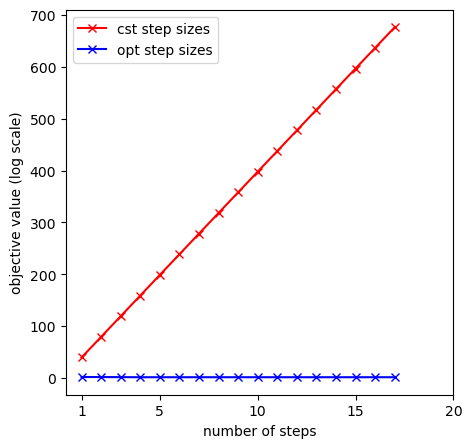

In [35]:

opt_obj_vals = []
cst_obj_values = []

for k in range(1, 20):
    vanilla_steps = np.ones((k,)) * (1/np.max(S))
    cst_obj_values.append(obj_value(W, vanilla_steps))
    opt_steps = regr_obj_value(W, mtx_optimal_regr(W, k)[1:])
    opt_obj_vals.append(opt_steps)
    
plt.plot(range(1, 20), np.log(cst_obj_values), "rx-", label="cst step sizes")
plt.plot(range(1, 20), np.log(opt_obj_vals), "bx-", label="opt step sizes")
plt.xticks([1] + list(range(5, 25, 5)))
plt.gcf().set_size_inches(5, 5)
plt.legend()
plt.xlabel('number of steps')
plt.ylabel('objective value (log scale)')
plt.savefig('convergence.pdf', dpi=120, bbox_inches='tight')
plt.show()

In [32]:
W = np.diag(10**np.arange(10))



In [ ]:
_gd_steps = 100
rand_projs = np.linalg.qr(np.random.normal(size=(_gd_steps, 2)))[0]

grid = np.arange(-0.0005, 0.0005, 0.00001)
coeffs = np.stack(np.meshgrid(grid, grid), axis=0)

regr_coeffs = np.einsum('ij,jkl->kli', rand_projs, coeffs)
regr_landscape = [[regr_obj_value(W, coeffs) for coeffs in row] for row in regr_coeffs]

steps_coeffs = np.einsum('ij,jkl->kli', rand_projs, coeffs)
steps_landscape = [[obj_value(W, coeffs) for coeffs in row] for row in regr_coeffs]

plt.subplot(1, 2, 1)
plt.title("regression coeffs loss landscape (log scale)")
plt.imshow(np.log(regr_landscape))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("gd steps loss landscape (log scale)")
plt.imshow(np.log(steps_landscape))
plt.colorbar()

plt.gcf().set_size_inches(20, 10)